# MLP-CW4 Experiment 6a 100x  execution notebook

This notebook is not for data exploration. But to log execution of experiments.

Experiment 6a
 - per magnification, segment the data on 6x6 grids using color thresholding, perform non-maximum suppression to find ideal cancdidate


## Imports

In [1]:
# set the matplotlib backend so figures can be saved in the background
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import keras
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2

import shutil
import fnmatch
import pickle
from keras import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import keras.initializers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import imgaug as ia
from imgaug import augmenters as iaa

/home/as12production/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Environment Settings

In [2]:
#Keras setting
K.set_image_dim_ordering('tf')  #Image dimension ordering

#Random seeds
SEED = 2082018
np.random.seed(SEED)

#Image Settings
IMAGE_RESIZE = (224,224)  # Image size. Process on the by data generator. Should match CNN model input. 
IMAGE_INPUT_SIZE = (224,224,3) #Image Input size to the neural network

#Training Settings
BATCH_SIZE = 32
EPOCH = 20

#Directories
# NOTE: The labels are determined by subfolders. PNG or JPEG images only.
TRAIN_DIR = '../TRAIN' 
VAL_DIR = '../VALID'
TEST_DIR =  '../TEST'


#["-40","-100-","-200-","-400-"]
magnifications = "-100-"
experiment_name = "experiment6a"

#Segmentaton
NUM_PATCH = 2   #2x2 grid patches

#Index of the class label represents numerical representation
CLASS_LABELS = ["Benign", "Malignant"]
NUM_CLASSES = 2
#Checkpoints and save files

#Saving every epochs that improve val accuracy
#MODEL_CHECKPOINT_FILE="baseline_model-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
# Rewriting save file for epoch that improves val accuracy
MODEL_CHECKPOINT_FILE="inception3-weights.hdf5"  

#Training charts and graphics
MODEL_TRAIN_RESULTS_FILE="inception3_train.pickle"
MODEL_ACCURACY_GRAPH_FILE="inception3_accuracy.pdf"
MODEL_LOSS_GRAPH_FILE="inception3_loss.pdf"
MODEL_EVALUATION_CM_FILE="inception3_CM.pdf"

## Loading Dataset

In [3]:
def buildImageDataset(path, imageResize=None,shuffle=False,seed=0):
    """
    Load dataset into an array. Labels are defined by folder name.
    """
    filenames = []
    data = []
    labels = []
    imagePaths = sorted(list(paths.list_images(path)))
    
    if shuffle == True:
        random.seed(seed)
        random.shuffle(imagePaths)

    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        if imageResize != None:
            image = cv2.resize(image, imageResize)
        image = img_to_array(image)
        data.append(image)
        filenames.append(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        labels.append(CLASS_LABELS.index(label))
    return (np.array(data), np.array(labels), np.array(filenames))

def showClassDistribution(y, labels):
    figure = plt.figure(figsize=(10,5))
    ax = sns.countplot(x = y)
    ax.set_xticklabels(labels)
    plt.show()

In [4]:
run_this = 1

# Load and save
if run_this == 1:
    X_train, y_train, train_files = buildImageDataset(TRAIN_DIR,imageResize=IMAGE_RESIZE,seed=SEED)
    X_valid, y_valid, valid_files = buildImageDataset(VAL_DIR,imageResize=IMAGE_RESIZE,seed=SEED)
    
    with open("X_train.pickle", "wb") as output_file:
            pickle.dump(X_train, output_file)

    with open("y_train.pickle", "wb") as output_file:
            pickle.dump(y_train, output_file)

    with open("X_valid.pickle", "wb") as output_file:
            pickle.dump(X_valid, output_file)

    with open("y_valid.pickle", "wb") as output_file:
            pickle.dump(y_valid, output_file)
    
# Quick load from saved files
if run_this == 2:
    X_train = pickle.load( open( "X_train.pickle", "rb" ) )
    y_train = pickle.load( open( "y_train.pickle", "rb" ) )
    X_valid = pickle.load( open( "X_valid.pickle", "rb" ) )
    y_valid = pickle.load( open( "y_valid.pickle", "rb" ) )


In [5]:

run_this = 1

if run_this == 1:
    validDataFrame = pd.DataFrame({'label':y_valid, 'filename':valid_files})
    trainDataFrame = pd.DataFrame({'label':y_train, 'filename':train_files})
    
    index = [i for i,item in enumerate(trainDataFrame["filename"]) if magnifications in item]
    X_train = X_train[index]
    y_train = y_train[index]
    train_files = train_files[index]
    
    index = [i for i,item in enumerate(validDataFrame["filename"]) if magnifications in item]
    X_valid = X_valid[index]
    y_valid = y_valid[index]
    valid_files = valid_files[index]
    

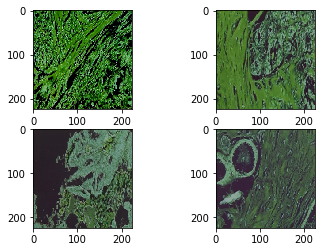

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(X_train[-1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(X_train[1])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(X_valid[-1])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(X_valid[1])

fig.savefig("rescaled"+magnifications+"images.pdf")

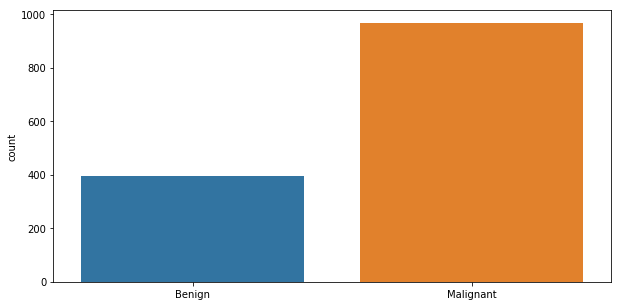

There are 1361 items in training set.


In [7]:
trainDataFrame = pd.DataFrame({'label':y_train, 'filename':train_files})
showClassDistribution(y_train, CLASS_LABELS)
print("There are {} items in training set.".format(len(y_train) ))

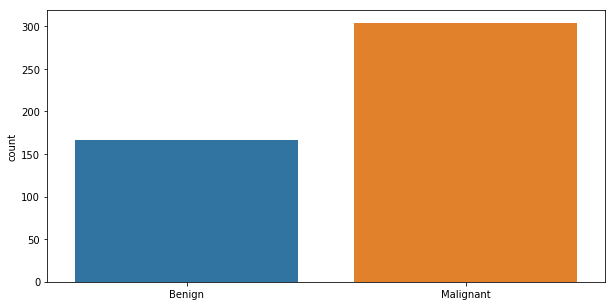

There are 470 items in validation set.


In [8]:
validDataFrame = pd.DataFrame({'label':y_valid, 'filename':valid_files})
showClassDistribution(y_valid, CLASS_LABELS)
print("There are {} items in validation set.".format(len(y_valid) ))

# Segmentation

In [9]:
#split images into regions

def splitImage(image, n_split, resize):
    """
    Takes a numpy image matrix, and split them based into nxn matrix
    return numpy matrix (regions, rows, columns, channel)
    """
    import numpy as np
    from scipy.misc import imresize 
    #Calculate region width and height
    block_r = int(np.floor(image.shape[0] / n_split))
    block_c = int(np.floor(image.shape[1] / n_split))
    
    result = []
    #Split the image based on block_r and block_c, and append it to result array
    row = 0
    for _ in range(0,n_split-1):
        col = 0
        start_r = row  * block_r
        for _ in range(0,n_split-1):
            start_c = col  * block_c
            result.append(imresize(image[start_r:start_r + block_r, start_c:start_c + block_c,:],resize))
            col += 1
        #Some images may not divide evenly, so use the remaining pixels on the last patch
        start_c = col * block_c
        result.append(imresize(image[start_r:start_r + block_r, start_c:,:],resize))
        row += 1
    #Some images may not divide evenly, so use the remaining pixels on the last patch
    start_r = row  * block_r
    col = 0
    for _ in range(0,n_split-1):
        start_c = col  * block_c
        result.append(imresize(image[start_r:, start_c:start_c + block_c,:],resize))
        col += 1
    #Some images may not divide evenly, so use the remaining pixels on the last patch
    start_c = col * block_c
    result.append(imresize(image[start_r:, start_c:, :],resize))
    return np.array(result).astype('float')/255.0


def regionScore(image, threshold=(0.5,0.5,0.5)):
    """
    Takes a numpy image matrix (row,col,channels) and associated threshold value for each channels.
    Return a copy of matrix with anything greater than or equal to threshold sets to 
    """
    import numpy as np
    
    def color_threshold(img, th):
        """
        Takes a numpy image matrix (row,col,channels) and associated threshold value for each channel. 
        Return a copy of matrix with anything greater than or equal to threshold sets to one and zero for everything else.
        """
        assert img.shape[2] == len(th), "number of channels must be equal to number of threshold"
        result = np.copy(img)
        for channel, value in enumerate(th):
            low_values_flags = result[:,:,channel] < value  # Where values are low
            high_values_flags = result[:,:,channel] >= value  # Where values are low
            result[low_values_flags,channel] = 1  # All low values set to 0
            result[high_values_flags,channel] = 0  # All low values set to 0
        return result
    return np.sum(color_threshold(image, threshold))

def segmentCell(set_of_images, resize , n_patch):
    cell = []
    for index, image in enumerate(set_of_images):
        score = []
        patches = []
        for patch in splitImage(image,n_patch,resize):
            score.append(regionScore(patch, threshold=(0.5,0.5,0.5)))
            patches.append(patch)
        # Non-Maximum suppression
        score = np.array(score)
        patches = np.array(patches)
        cell.append(patches[np.argmax(score)])
    return np.array(cell)

/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


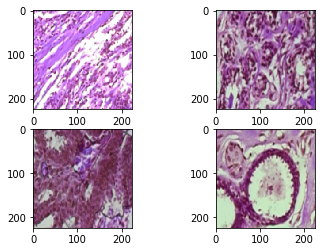

In [10]:
X_train /= 255.0
X_valid /= 255.0
X_tr = segmentCell(X_train, IMAGE_RESIZE, NUM_PATCH)
X_vl = segmentCell(X_valid, IMAGE_RESIZE, NUM_PATCH)
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
X_train = X_tr
X_valid = X_vl

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(X_train[-1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(X_train[1])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(X_valid[-1])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(X_valid[1])
fig.savefig(str(NUM_PATCH)+"x"+str(NUM_PATCH)+"-segmented-"+magnifications+"-images.pdf")

# Building Neural Net Model

In [11]:
# Building Models
def InceptionNet():
    #https://keras.io/applications/#inceptionv3
    #Use Inception 3 without the last layer.
    #Replace last layer with 1 sigmoid for binary classification
    sgd = SGD(lr=0.01, momentum=0.9,nesterov=False)
    model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                                        weights='imagenet',  #Pre-train on ImageNet 
                                                        input_tensor=Input(shape=IMAGE_INPUT_SIZE),
                                                        input_shape=None,
                                                        pooling='avg',
                                                        classes=NUM_CLASSES)
    final = Model(input=model.input,output=Dense(NUM_CLASSES, activation='softmax')(model.output))
    final.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])    
    return final

# Required Function Definitions

In [12]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    plot = plt.figure()
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return plot

In [13]:
def generateTrainingPlots(history, accuracy_grap_file, loss_graph_file):
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(15,10))
    for k in ['val_acc', 'acc']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylim((0,1.2))
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(15,10))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()
    #Save visualization data    
    accuracy_plot.savefig(accuracy_grap_file, bbox_inches='tight')
    loss_plot.savefig(loss_graph_file, bbox_inches='tight')


In [14]:
def evaluateClassifier(history, classifier, weights, X ,y , cm_file, out_file, classlabels):
    classifier.load_weights(weights)
    y_pred = classifier.predict(X)
    cm = confusion_matrix(np.argmax(y,axis=1), np.argmax(np.rint(y_pred),axis=1))
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plot_confusion_matrix(cm_norm, classes=classlabels)
    plot.savefig(cm_file, bbox_inches='tight')
    scores = classifier.evaluate(X_valid,y_valid)
    with open(out_file, 'w') as the_file:
        the_file.write("Max Val Acc: " + str(np.max(np.array(history['val_acc']))))
        the_file.write("\nMin Val Acc: " + str(np.min(np.array(history['val_acc']))))
        the_file.write("\nMax Train Acc: "  + str(np.max(np.array(history['acc']))))
        the_file.write("\nMin Train Acc: "  + str(np.min(np.array(history['acc']))))
        the_file.write("\nMax Val Err: "  + str(np.max(np.array(history['val_loss']))))
        the_file.write("\nMin Val Err: " + str(np.min(np.array(history['val_loss']))))
        the_file.write("\nMax Train Err: " + str(np.max(np.array(history['loss']))))
        the_file.write("\nMin Train Err: " +  str(np.min(np.array(history['loss']))))
        the_file.write("\nResult: " + str(scores))
        the_file.write("\nResult: " +  str(model.metrics_names))
        

# Training & Visualizing & Evaluating

Running Experiment Iteration 1


/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Train on 1361 samples, validate on 470 samples
Epoch 1/20
1361/1361 [==============================] - 43s 31ms/step - loss: 0.3773 - acc: 0.8347 - val_loss: 1.0479 - val_acc: 0.6383

Epoch 00001: val_acc improved from -inf to 0.63830, saving model to run#1_experiment6a-100-inception3-weights.hdf5
Epoch 2/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.1820 - acc: 0.9317 - val_loss: 0.8213 - val_acc: 0.6660

Epoch 00002: val_acc improved from 0.63830 to 0.66596, saving model to run#1_experiment6a-100-inception3-weights.hdf5
Epoch 3/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.0732 - acc: 0.9794 - val_loss: 1.5173 - val_acc: 0.6723

Epoch 00003: val_acc improved from 0.66596 to 0.67234, saving model to run#1_experiment6a-100-inception3-weights.hdf5
Epoch 4/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.0933 - acc: 0.9662 - val_loss: 3.6433 - val_acc: 0.5745

Epoch 00004: val_acc did not improve
Epoch 5/20
1361/1

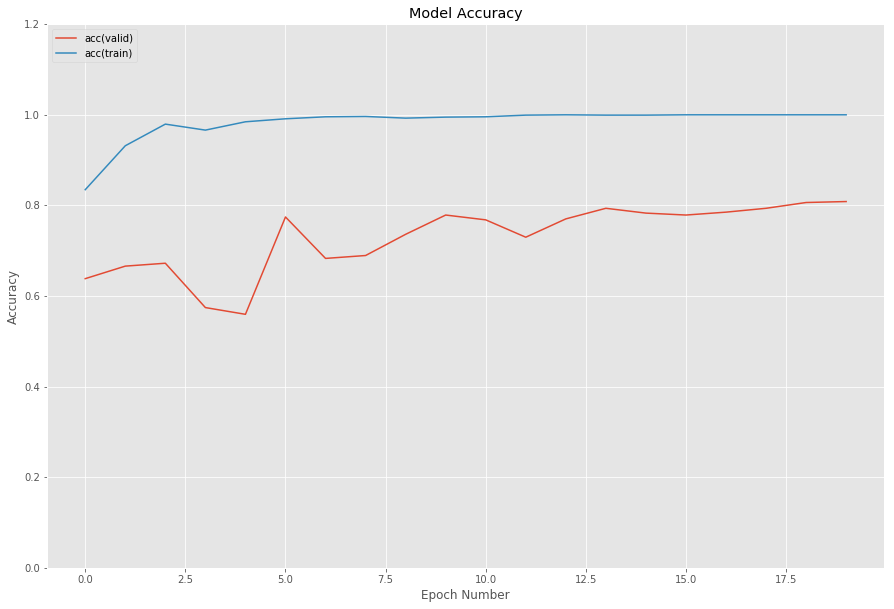

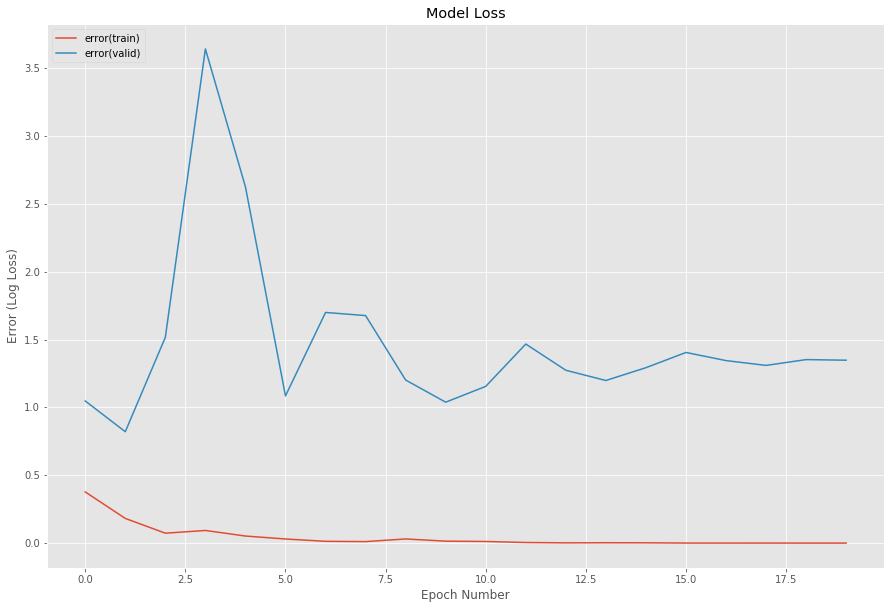

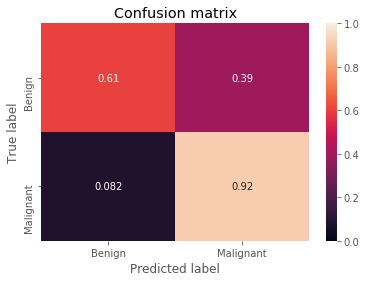

470/470 [==============================] - 5s 11ms/step
Running Experiment Iteration 2


/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Train on 1361 samples, validate on 470 samples
Epoch 1/20
1361/1361 [==============================] - 43s 31ms/step - loss: 0.3949 - acc: 0.8259 - val_loss: 3.0795 - val_acc: 0.3851

Epoch 00001: val_acc improved from -inf to 0.38511, saving model to run#2_experiment6a-100-inception3-weights.hdf5
Epoch 2/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.1678 - acc: 0.9456 - val_loss: 6.6579 - val_acc: 0.3553

Epoch 00002: val_acc did not improve
Epoch 3/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.1144 - acc: 0.9566 - val_loss: 3.2583 - val_acc: 0.5574

Epoch 00003: val_acc improved from 0.38511 to 0.55745, saving model to run#2_experiment6a-100-inception3-weights.hdf5
Epoch 4/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.0685 - acc: 0.9765 - val_loss: 1.2992 - val_acc: 0.7872

Epoch 00004: val_acc improved from 0.55745 to 0.78723, saving model to run#2_experiment6a-100-inception3-weights.hdf5
Epoch 5/20
1361/1

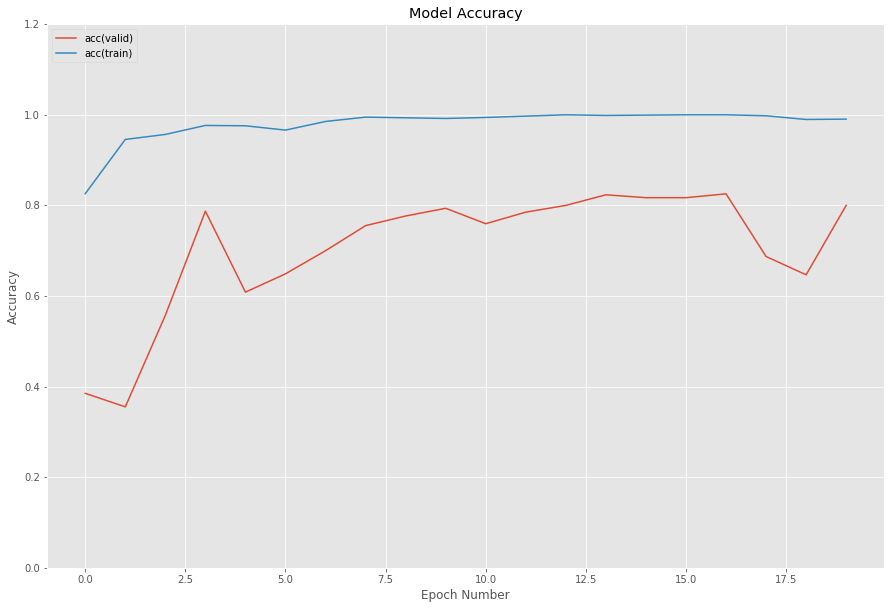

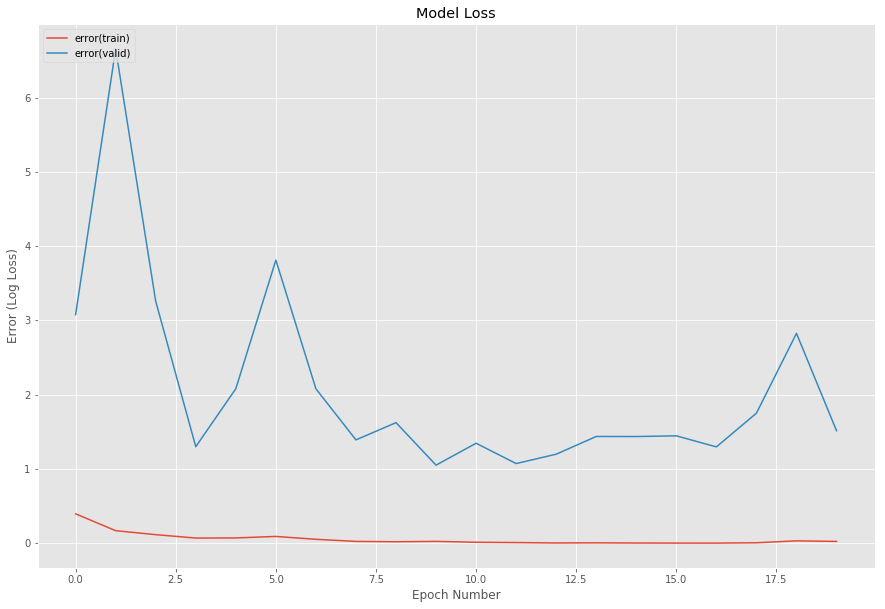

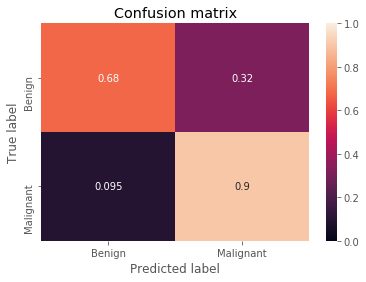

470/470 [==============================] - 7s 15ms/step
Running Experiment Iteration 3
Train on 1361 samples, validate on 470 samples
Epoch 1/20
1361/1361 [==============================] - 48s 35ms/step - loss: 0.3961 - acc: 0.8369 - val_loss: 1.0034 - val_acc: 0.4426

Epoch 00001: val_acc improved from -inf to 0.44255, saving model to run#3_experiment6a-100-inception3-weights.hdf5
Epoch 2/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.2065 - acc: 0.9221 - val_loss: 3.0419 - val_acc: 0.4851

Epoch 00002: val_acc improved from 0.44255 to 0.48511, saving model to run#3_experiment6a-100-inception3-weights.hdf5
Epoch 3/20
1361/1361 [==============================] - 35s 25ms/step - loss: 0.1024 - acc: 0.9603 - val_loss: 1.4545 - val_acc: 0.7404

Epoch 00003: val_acc improved from 0.48511 to 0.74043, saving model to run#3_experiment6a-100-inception3-weights.hdf5
Epoch 4/20
1361/1361 [==============================] - 34s 25ms/step - loss: 0.0881 - acc: 0.9758 - val

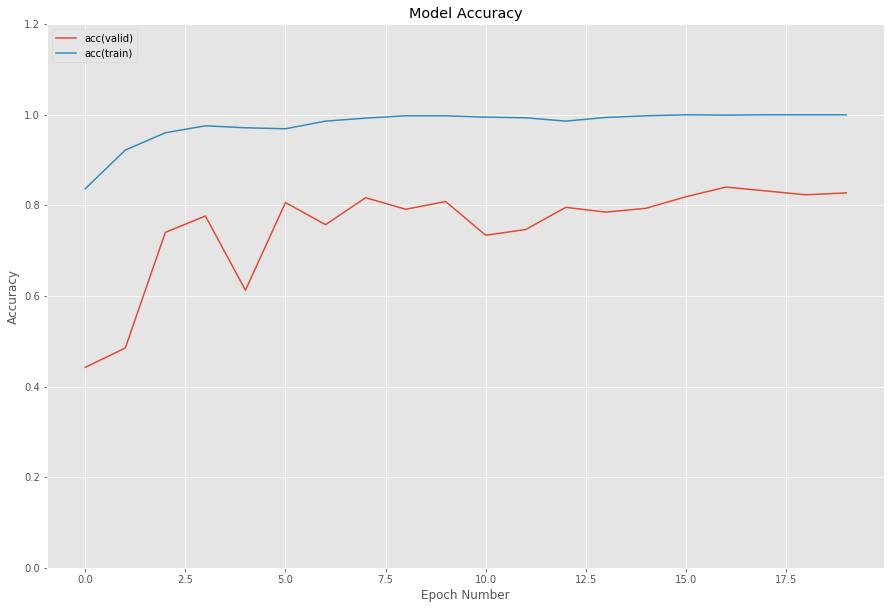

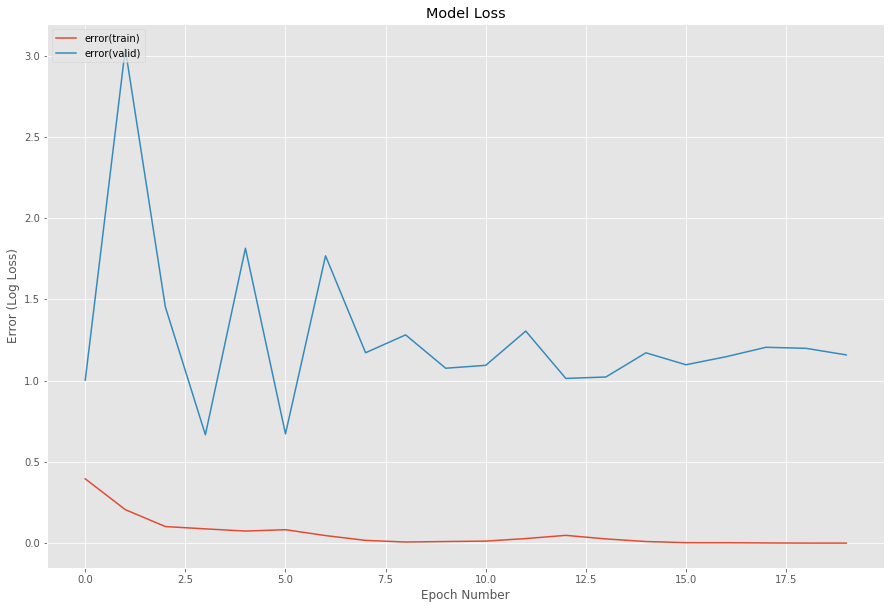

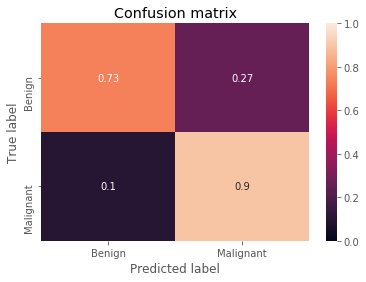

470/470 [==============================] - 9s 19ms/step


In [15]:
for i in range(1,4):
    print("Running Experiment Iteration",i)
    model = InceptionNet()
    #Process filenames
    prefix = "run#{}_".format(i)
    MODEL_CHECKPOINT_FILE=prefix + experiment_name + magnifications+"inception3-weights.hdf5"  
    #Training charts and graphics
    MODEL_TRAIN_RESULTS_FILE=prefix + experiment_name + magnifications+"inception3_train.pickle"
    MODEL_ACCURACY_GRAPH_FILE=prefix + experiment_name + magnifications+"inception3_accuracy.pdf"
    MODEL_LOSS_GRAPH_FILE=prefix + experiment_name + magnifications+"inception3_loss.pdf"
    MODEL_EVALUATION_CM_FILE=prefix + experiment_name + magnifications+"inception3_CM.pdf"
    MODEL_EVALUATION_TEXT_FILE=prefix + experiment_name + magnifications+"inception3_eval.txt"
    
    checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    #Training
    history = model.fit(x=X_train,y=y_train,
                        validation_data=(X_valid,y_valid),
                        batch_size=BATCH_SIZE,
                        epochs = EPOCH,
                        callbacks = callbacks_list)
    
    #Saving training result
    with open(MODEL_TRAIN_RESULTS_FILE, "wb") as output_file:
        pickle.dump(history.history, output_file)    
    
    #Generate training graphs
    generateTrainingPlots(history.history, MODEL_ACCURACY_GRAPH_FILE, MODEL_LOSS_GRAPH_FILE)
    
    #evaluate classifier
    evaluateClassifier(history.history, InceptionNet(), MODEL_CHECKPOINT_FILE, 
                       X_valid ,y_valid , MODEL_EVALUATION_CM_FILE, MODEL_EVALUATION_TEXT_FILE, CLASS_LABELS)
    del model

In [ ]:
print("Completed")

Completed


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>